In [4]:
import pandas as pd
import os
import numpy as np
import csv
import pytz
import time
from datetime import datetime
from collections import Counter

import tweepy
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream

# A package which could be used to check whether an account is a bot
import botometer

import matplotlib.pyplot as plt

In [5]:
pd.options.display.max_rows = 30

In [6]:
tweet_2017_path_raw = r'C:\CityU\Datasets\hong_kong_tweet_2017'
tweet_2016_path_raw = r'C:\CityU\Datasets\hong_kong_tweet_2016'
desktop = r'C:\Users\hlchang4.DS039047\Desktop'
# saving_path = r'F:\CityU\Datasets'
# tweet_filtering_path = r'F:\CityU\Datasets\tweet_filtering'
bot_check_path = r'C:\CityU\Datasets\check_bots'
bot_check_figure_path = r'C:\CityU\Datasets\check_bots\Figures'
visitor_data_save_path = r'C:\Users\hlchang4.DS039047\Desktop\visitor_data'
visitor_botometer_check_path = r'C:\Users\hlchang4.DS039047\Desktop\visitor_data\visitor_botometer_check'


# Hong Kong and Shanghai share the same time zone.
# Hence, we transform the utc time in our dataset into Shanghai time
time_zone_hk = pytz.timezone('Asia/Shanghai')

In [7]:
# Set some account information
# For more details, please go to: https://github.com/IUNetSci/botometer-python
mashape_key = "rtK5JMlxZdmshWdnzuqK3N9C0Z6Np1uxx4hjsnFQIPb7U6tfw3"
twitter_app_auth = {
    'consumer_key': 'dXkaXPMI57d9qwo9Z5yvqcgRW',
    'consumer_secret': 'RYQtYtd2OSDyGOQrP75n1qZSCAEcPArhuWgpDJSVq1XaiMB7tb',
    'access_token': '3586804034-n24NEGjhOQnnXYZy2NRkDHMViFm8Cms5D0ZLzNo',
    'access_token_secret': 'EPYBRomDyb8x2alwgqZ4rvhSdydDqn0zICf9MGZWW15wp',
  }
bom = botometer.Botometer(wait_on_ratelimit=True,
                          mashape_key=mashape_key,
                          **twitter_app_auth)

auth = OAuthHandler("dXkaXPMI57d9qwo9Z5yvqcgRW", "RYQtYtd2OSDyGOQrP75n1qZSCAEcPArhuWgpDJSVq1XaiMB7tb")

auth.set_access_token('3586804034-n24NEGjhOQnnXYZy2NRkDHMViFm8Cms5D0ZLzNo', 'EPYBRomDyb8x2alwgqZ4rvhSdydDqn0zICf9MGZWW15wp')

api = tweepy.API(auth)

# Construct the API instance
api = tweepy.API(auth)

# 1. Load some functions

In [8]:
# read multiple csv files from a local directory
def read_text_from_multi_csvs(path):
    all_csv_files = os.listdir(path)
    dataframes = []
    for file in all_csv_files:
        dataframe = pd.read_csv(os.path.join(path, file), encoding='latin-1', dtype='str', 
                                quoting=csv.QUOTE_NONNUMERIC)
        dataframes.append(dataframe)
    combined_dataframes = pd.concat(dataframes, sort=True)
    return combined_dataframes

def read_local_csv_file(path, filename):
    dataframe = pd.read_csv(os.path.join(path, filename), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC, dtype='str', 
                            index_col=0)
    return dataframe

# Function used to output a pandas dataframe for each user based on the user account number
def derive_dataframe_for_each_user(df, all_users):
    dataframes = []
    print('Total number of users is {}'.format(len(all_users)))
    count = 1
    for user in all_users:
        if count % 1000 == 0:
            print('The first {} users have been processed'.format(count))
        dataframes.append(df.loc[df['user_id_str']==user])
        count += 1
    print('Done!')
    return dataframes

# Based on the dataframe for each user, compute the time range between his or her first tweet and last tweet
def compute_time_range_for_one_user(df):
    user_id_str = list(df['user_id_str'])[0]
    first_row_time_object = list(df.head(1)['hk_time'])[0]
    end_row_time_object = list(df.tail(1)['hk_time'])[0]
    time_range = end_row_time_object - first_row_time_object
    return (user_id_str, time_range.days)

# Add a new colume named hk_time
def get_hk_time(df):
    changed_time_list = []
    for _, row in df.iterrows():
        time_to_change = datetime.strptime(row['created_at'], '%a %b %d %H:%M:%S %z %Y')
        # get the hk time
        changed_time = time_to_change.astimezone(time_zone_hk)
        changed_time_list.append(changed_time)
    df['hk_time'] = changed_time_list
    return df

# Output 
def number_of_tweet_user(df):
    user_num = len(set(df['user_id_str']))
    tweet_num = df.shape[0]
    print('Total number of tweet is: {}; Total number of user is {}'.format(
        tweet_num, user_num))

In [9]:
def delete_bots_have_same_geoinformation(df, prop_threshold=0.70):
    users = set(list(df['user_id_str']))
    bot_account = []
    for user in users:
        dataframe = df.loc[df['user_id_str']==user]
        lat_counter = Counter(dataframe['lat'])
        lon_counter = Counter(dataframe['lon'])
        decide = (compute_the_highest_proportion_from_counter(lat_counter, prop_threshold)) or (compute_the_highest_proportion_from_counter(lon_counter, prop_threshold))
        # If only one unqiue geoinformation is found and more than 10 tweets are posted, we regard this account as bot
        if decide:
            bot_account.append(user)
        else:
            pass
    print('Done!')
    cleaned_df = df.loc[~df['user_id_str'].isin(bot_account)]
#     cleaned_df.to_pickle(os.path.join(saving_path, file_name))
    return cleaned_df

def compute_the_highest_proportion_from_counter(counter_dict, prop_threshold):
    total_count = sum(counter_dict.values())
    result = False
    for latitude in list(counter_dict.keys()):
        if counter_dict[latitude]/total_count > prop_threshold:
            result = True
            return result
        else:
            pass
    return result

def compute_tweet_num_geo_prop(df):
    user_set = set(df['user_id_str'])
    result_list = []
    for user in user_set:
        user_dataframe = df.loc[df['user_id_str'] == user]
        tweet_num = user_dataframe.shape[0]
        prop_num_lat = max(list(Counter(user_dataframe['lat']).values()))/sum(Counter(user_dataframe['lat']).values())
        prop_num_lon = max(list(Counter(user_dataframe['lon']).values()))/sum(Counter(user_dataframe['lon']).values())
        prop_num = max(prop_num_lat, prop_num_lon)
        result_list.append((tweet_num, prop_num))
    return result_list

In [10]:
def find_unuseful_geoinformation(df):
    wrong_list = []
    for _, row in df.iterrows():
        try:
            float(row['lat'])
        except:
            wrong_list.append(row['lat'])
    return wrong_list

In [11]:
def check_bot(id_str):
    result = bom.check_account(id_str)
    return result['cap']['universal']

In [12]:
def plot_cumulative(number_list, bin_num, color, title, xlabel, ylabel, saving_path, file_name):
    
    fig, ax = plt.subplots(1,1,figsize=(10,10), dpi=300)
    
    values, base = np.histogram(number_list, bins=bin_num)
    #evaluate the cumulative
    cumulative = np.cumsum(values)
    # plot the cumulative function

    plt.plot(base[:-1], cumulative, c=color)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    fig.savefig(os.path.join(saving_path, file_name))
    plt.show()

# 2. Read the visitor dataframe

The following steps have been processed:

1. Only consider the English and Chinese tweets
2. Remove the verified accounts
3. Only consider the tweets have geoinformation

In [13]:
visitor_data = read_local_csv_file(path=visitor_data_save_path, filename='visitor_data.csv')

In [15]:
number_of_tweet_user(visitor_data)

Total number of tweet is: 103568; Total number of user is 42108


In [22]:
selected_name_list = ['country', 'country_code', 'created_at', 'description',
       'expanded_url', 'favorited', 'favourites_count',
       'followers_count', 'friends_count', 'full_name', 'geo_enabled',
       'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id_str',
       'in_reply_to_user_id_str', 'lang', 'lat', 'listed_count', 'location',
       'lon', 'name', 'place_id', 'place_lat', 'place_lon', 'place_name',
       'place_type', 'protected', 'retweet_count', 'retweeted', 'screen_name',
       'source', 'statuses_count', 'text', 'time_zone', 'truncated', 'url',
       'user_created_at', 'user_id_str', 'user_lang', 'user_url', 'utc_offset',
       'verified', 'hk_time', 'year', 'month', 'month_plus_year']
len(selected_name_list)

46

In [23]:
Counter(visitor_data['lang'])

Counter({'en': 81461, 'zh': 22107})

In [24]:
visitor_data_selected = visitor_data[selected_name_list]

In [25]:
visitor_data_selected.head()

,country,country_code,created_at,description,expanded_url,favorited,favourites_count,followers_count,friends_count,full_name,...,user_created_at,user_id_str,user_lang,user_url,utc_offset,verified,hk_time,year,month,month_plus_year
20,<U+9999><U+6E2F>,HK,Sat May 07 07:02:34 +0000 2016,UX Specialist & Senior Creative Multimedia Des...,https://www.instagram.com/p/BFGNCHPEXO_/,FALSE,53,102,124,"Islands District, Hong Kong",...,Thu Feb 19 05:16:04 +0000 2009,21278240,en,http://kotakitam.wordpress.com,28800,FALSE,2016-05-07 15:02:34+08:00,2016,5,2016_5
46,<U+9999><U+6E2F>,HK,Sat May 07 07:08:35 +0000 2016,NaN,https://www.instagram.com/p/BFGNuKlvccc/,FALSE,55,265,1002,"Yau Tsim Mong District, Hong Kong",...,Fri Mar 20 01:53:31 +0000 2009,25434706,en,http://www.karlynnholbrook.com,-14400,FALSE,2016-05-07 15:08:35+08:00,2016,5,2016_5
52,<U+9999><U+6E2F>,HK,Sat May 07 07:09:26 +0000 2016,Son of the BEACH!!!,https://www.instagram.com/p/BFGN0JAPgwG/,FALSE,46,270,126,"Islands District, Hong Kong",...,Thu Sep 24 08:20:45 +0000 2009,76890100,en,NaN,25200,FALSE,2016-05-07 15:09:26+08:00,2016,5,2016_5
73,<U+9999><U+6E2F>,HK,Sat May 07 07:12:35 +0000 2016,Son of the BEACH!!!,https://path.com/p/NMFVX,FALSE,46,270,126,"Islands District, Hong Kong",...,Thu Sep 24 08:20:45 +0000 2009,76890100,en,NaN,25200,FALSE,2016-05-07 15:12:35+08:00,2016,5,2016_5
74,<U+4E2D><U+534E><U+4EBA><U+6C11><U+5171><U+548...,CN,Sat May 07 07:12:39 +0000 2016,"loves science, music, lots of TV shows, movies...",https://www.instagram.com/p/BFGOMAuGCI1/,FALSE,200,210,506,"Guangdong, People's Republic of China",...,Sat Apr 18 16:39:17 +0000 2009,32935378,en,http://shenanigansinc.tumblr.com/,28800,FALSE,2016-05-07 15:12:39+08:00,2016,5,2016_5


In [26]:
Counter(visitor_data_selected['year'])

Counter({'2016': 47156, '2017': 56351, '2018': 61})

In [27]:
visitor_data_selected[['url', 'expanded_url', 'created_at', 'hk_time']].head()

,url,expanded_url,created_at,hk_time
20,https://t.co/5vwsCLv80G,https://www.instagram.com/p/BFGNCHPEXO_/,Sat May 07 07:02:34 +0000 2016,2016-05-07 15:02:34+08:00
46,https://t.co/Ihs9cIJ2In,https://www.instagram.com/p/BFGNuKlvccc/,Sat May 07 07:08:35 +0000 2016,2016-05-07 15:08:35+08:00
52,https://t.co/vyfAl47I4v,https://www.instagram.com/p/BFGN0JAPgwG/,Sat May 07 07:09:26 +0000 2016,2016-05-07 15:09:26+08:00
73,https://t.co/aMOjEeZg9R,https://path.com/p/NMFVX,Sat May 07 07:12:35 +0000 2016,2016-05-07 15:12:35+08:00
74,https://t.co/E53q4Asb9A,https://www.instagram.com/p/BFGOMAuGCI1/,Sat May 07 07:12:39 +0000 2016,2016-05-07 15:12:39+08:00


# 3. Get the data for 2016 and 2017 seperately

In [28]:
visitor_dataframe_2017 = visitor_data_selected.loc[visitor_data_selected['year'] == '2017']
visitor_dataframe_2016 = visitor_data_selected.loc[visitor_data_selected['year'] == '2016']

In [29]:
# Some geoinformation of rows is not useful enough
wrong_list_2016 = find_unuseful_geoinformation(visitor_dataframe_2016)
wrong_list_2017 = find_unuseful_geoinformation(visitor_dataframe_2017)

In [30]:
print(wrong_list_2016, wrong_list_2017)

[] []


In [31]:
visitor_dataframe_2016_copy = visitor_dataframe_2016.copy()
visitor_dataframe_2017_copy = visitor_dataframe_2017.copy()

In [32]:
visitor_dataframe_2016_copy[["lat", "lon"]] = visitor_dataframe_2016_copy[["lat", "lon"]].astype(np.float64)
visitor_dataframe_2017_copy[["lat", "lon"]] = visitor_dataframe_2017_copy[["lat", "lon"]].astype(np.float64)

### Save the ids

In [33]:
visitor_2016_ids = np.array(list(visitor_dataframe_2016_copy['user_id_str']))
visitor_2017_ids = np.array(list(visitor_dataframe_2017_copy['user_id_str']))

In [34]:
np.save(os.path.join(visitor_data_save_path, 'visitor_tweet_2016_ids.npy'), visitor_2016_ids)
np.save(os.path.join(visitor_data_save_path, 'visitor_tweet_2017_ids.npy'), visitor_2017_ids)

In [35]:
print('The shape of the visitor 2016 ids is {}; The shape of the visiotr 2017 id is {}'.format(
    np.shape(visitor_2016_ids), np.shape(visitor_2017_ids)))

The shape of the visitor 2016 ids is (47156,); The shape of the visiotr 2017 id is (56351,)


### Save the dataframes

In [36]:
visitor_dataframe_2016_copy.to_csv(os.path.join(visitor_data_save_path, 'visitor_dataframe_2016.csv'), encoding='utf-8', 
                                  quoting=csv.QUOTE_NONNUMERIC)

In [37]:
visitor_dataframe_2017_copy.to_csv(os.path.join(visitor_data_save_path, 'visitor_dataframe_2017.csv'), encoding='utf-8', 
                                  quoting=csv.QUOTE_NONNUMERIC)

In [38]:
combined_visitor_dataframe = pd.concat([visitor_dataframe_2016_copy, visitor_dataframe_2017_copy], axis=0)

In [39]:
combined_visitor_dataframe['index_num'] = list(range(combined_visitor_dataframe.shape[0]))

In [40]:
combined_visitor_dataframe.tail()

,country,country_code,created_at,description,expanded_url,favorited,favourites_count,followers_count,friends_count,full_name,...,user_id_str,user_lang,user_url,utc_offset,verified,hk_time,year,month,month_plus_year,index_num
408,Hong Kong,HK,Sun Dec 31 15:43:13 +0000 2017,OBGH x UA&P // I-SA x ViARE x PEER // Serving ...,https://www.instagram.com/p/BdXz8cvlOc0/,FALSE,489,116,114,"Tsuen Wan District, Hong Kong",...,445110850,en,http://www.facebook.com/dj.narag,-32400,FALSE,2017-12-31 23:43:13+08:00,2017,12,2017_12,103502
425,é¦æ¸¯,HK,Sun Dec 31 15:45:23 +0000 2017,designerã»è¨­è¨å¸«\r\nhttp://wongwangchi.tum...,https://www.instagram.com/p/BdXzQfHAjO9/,FALSE,35,27,156,"èç£, é¦æ¸¯",...,344811541,zh-tw,http://wongwangchi.tumblr.com/,28800,FALSE,2017-12-31 23:45:23+08:00,2017,12,2017_12,103503
460,Hong Kong,HK,Sun Dec 31 15:51:07 +0000 2017,NaN,https://www.instagram.com/p/BdXxVBKHv2lX5kxzg6...,FALSE,13432,196,125,"Central & Western District, Hong Kong",...,433944707,en,NaN,28800,FALSE,2017-12-31 23:51:07+08:00,2017,12,2017_12,103504
501,Hong Kong,HK,Sun Dec 31 15:55:54 +0000 2017,Benildean-Lasallian | 114 í ¼í¾¥: http://goo.g...,https://www.instagram.com/p/BdX1ZtIBP-K/,FALSE,1085,355,536,"Yau Tsim Mong District, Hong Kong",...,121942320,en,http://Instagram.com/chuabblees,28800,FALSE,2017-12-31 23:55:54+08:00,2017,12,2017_12,103505
506,Hong Kong,HK,Sun Dec 31 15:56:04 +0000 2017,"âLife is to be enjoyed, not endured.â -Gor...",https://www.instagram.com/p/BdX1auNBTzJmDpb3V8...,FALSE,8033,860,595,"Wan Chai District, Hong Kong",...,363142675,en,NaN,28800,FALSE,2017-12-31 23:56:04+08:00,2017,12,2017_12,103506


In [41]:
visitor_dataframe_2016_copy = combined_visitor_dataframe.loc[combined_visitor_dataframe['year'] == '2016']
visitor_dataframe_2017_copy = combined_visitor_dataframe.loc[combined_visitor_dataframe['year'] == '2017']

In [42]:
visitor_dataframe_2016_copy.columns

Index(['country', 'country_code', 'created_at', 'description', 'expanded_url',
       'favorited', 'favourites_count', 'followers_count', 'friends_count',
       'full_name', 'geo_enabled', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'lang', 'lat',
       'listed_count', 'location', 'lon', 'name', 'place_id', 'place_lat',
       'place_lon', 'place_name', 'place_type', 'protected', 'retweet_count',
       'retweeted', 'screen_name', 'source', 'statuses_count', 'text',
       'time_zone', 'truncated', 'url', 'user_created_at', 'user_id_str',
       'user_lang', 'user_url', 'utc_offset', 'verified', 'hk_time', 'year',
       'month', 'month_plus_year', 'index_num'],
      dtype='object')

### Save the geoinformation of 2016 and 2017 data

In [43]:
visitor_dataframe_2016_geoinfo = visitor_dataframe_2016_copy[['lat', 'lon', 'index_num']]
visitor_dataframe_2017_geoinfo = visitor_dataframe_2017_copy[['lat', 'lon', 'index_num']]

In [44]:
visitor_dataframe_2016_geoinfo.shape

(47156, 3)

In [45]:
visitor_dataframe_2017_geoinfo.shape

(56351, 3)

In [46]:
visitor_dataframe_2016_geoinfo.to_csv(os.path.join(visitor_data_save_path, 'visitor_2016_geoinfo.csv'), encoding='utf-8', 
                                     quoting=csv.QUOTE_NONNUMERIC)

In [47]:
visitor_dataframe_2017_geoinfo.to_csv(os.path.join(visitor_data_save_path, 'visitor_2017_geoinfo.csv'), encoding='utf-8', 
                                     quoting=csv.QUOTE_NONNUMERIC)

In [48]:
visitor_dataframe_2016_geoinfo.head()

,lat,lon,index_num
20,22.276808,113.916187,0
46,22.296341,114.168672,1
52,22.308889,113.914444,2
73,22.311590,113.926890,3
74,22.537514,113.969756,4


In [49]:
combined_data_2016_2017 = pd.concat([visitor_dataframe_2016_copy, visitor_dataframe_2017_copy], axis=0)

In [50]:
combined_data_2016_2017.shape

(103507, 47)

# 4. Use ArcMap to find tweets in HK

We feed the ```visitor_dataframe_2016_geoinfo``` and the ```visitor_dataframe_2017_geoinfo``` to the ArcMap and check which tweets are actually posted in HK.

Finally, we get two csv files: ```visitor_2016_tpuinfo_hk.csv``` and ```visitor_2017_tpuinfo_hk.csv```. We then load them to continue the analysis.

In [51]:
visitor_2016_tpuinfo_hk = read_local_csv_file(path=visitor_data_save_path, filename='visitor_2016_tpuinfo_hk.csv')
visitor_2017_tpuinfo_hk = read_local_csv_file(path=visitor_data_save_path, filename='visitor_2017_tpuinfo_hk.csv')

In [52]:
visitor_2016_tpuinfo_hk.shape

(39217, 8)

In [53]:
visitor_2017_tpuinfo_hk.shape

(45369, 8)

In [54]:
visitor_2016_tpuinfo_hk.columns

Index(['Field1', 'lat', 'lon', 'index_num', 'FID_2', 'FID_1_1', 'merge_Nums',
       'SmallTPU'],
      dtype='object')

In [55]:
combined_data_tpu_hk = pd.concat([visitor_2016_tpuinfo_hk, visitor_2017_tpuinfo_hk], axis=0)

In [56]:
combined_data_index_list = list(combined_data_tpu_hk['index_num'])

In [57]:
combined_data_index_list_int = [int(value) for value in combined_data_index_list]

### Get the data in Hong Kong

In [58]:
visitor_hk = combined_data_2016_2017.loc[combined_data_2016_2017['index_num'].isin(combined_data_index_list_int)]

In [59]:
visitor_hk.shape

(84586, 47)

In [60]:
visitor_hk.to_csv(os.path.join(visitor_data_save_path, 'all_visitor_hk.csv'), encoding='utf-8', quoting=csv.QUOTE_NONNUMERIC)

In [61]:
number_of_tweet_user(visitor_hk)

Total number of tweet is: 84586; Total number of user is 33189


# 5. Delete the bots

Firstly, use my own function

In [62]:
visitor_without_bot_step1 = delete_bots_have_same_geoinformation(visitor_hk, prop_threshold=0.6)

Done!


In [63]:
visitor_without_bot_step1.shape

(55497, 47)

In [64]:
visitor_without_bot_step1.head()

,country,country_code,created_at,description,expanded_url,favorited,favourites_count,followers_count,friends_count,full_name,...,user_id_str,user_lang,user_url,utc_offset,verified,hk_time,year,month,month_plus_year,index_num
20,<U+9999><U+6E2F>,HK,Sat May 07 07:02:34 +0000 2016,UX Specialist & Senior Creative Multimedia Des...,https://www.instagram.com/p/BFGNCHPEXO_/,FALSE,53,102,124,"Islands District, Hong Kong",...,21278240,en,http://kotakitam.wordpress.com,28800,FALSE,2016-05-07 15:02:34+08:00,2016,5,2016_5,0
52,<U+9999><U+6E2F>,HK,Sat May 07 07:09:26 +0000 2016,Son of the BEACH!!!,https://www.instagram.com/p/BFGN0JAPgwG/,FALSE,46,270,126,"Islands District, Hong Kong",...,76890100,en,NaN,25200,FALSE,2016-05-07 15:09:26+08:00,2016,5,2016_5,2
73,<U+9999><U+6E2F>,HK,Sat May 07 07:12:35 +0000 2016,Son of the BEACH!!!,https://path.com/p/NMFVX,FALSE,46,270,126,"Islands District, Hong Kong",...,76890100,en,NaN,25200,FALSE,2016-05-07 15:12:35+08:00,2016,5,2016_5,3
84,<U+9999><U+6E2F>,HK,Sat May 07 07:13:34 +0000 2016,"1992, psychology, liberal arts, thammasat univ...",https://www.swarmapp.com/c/dxP57kckrQa,FALSE,2661,480,186,"Central & Western District, Hong Kong",...,64168725,en,NaN,-25200,FALSE,2016-05-07 15:13:34+08:00,2016,5,2016_5,7
113,<U+9999><U+6E2F>,HK,Sat May 07 07:18:00 +0000 2016,NaN,https://www.instagram.com/p/BFGOzG4yG_n8foZ7Ob...,FALSE,1042,74,107,"Wan Chai District, Hong Kong",...,143025282,en,NaN,25200,FALSE,2016-05-07 15:18:00+08:00,2016,5,2016_5,8


In [65]:
visitor_without_bot_step1.to_csv(os.path.join(visitor_data_save_path, 'visitor_without_bot_step1.csv'), encoding='utf-8', 
                                quoting=csv.QUOTE_NONNUMERIC)

Then, we use botometer to filter bots

In [66]:
user_id_list = list(set(visitor_without_bot_step1['user_id_str']))
len(user_id_list)

10454

In [67]:
print('Check bots starts....')
bot_result_list = []
processed_account_list = []
account_with_error = []
# The input of the check bot function should be integers
account_integers = [int(number) for number in user_id_list]
# Get a set of unique users and transform it to list
account_integer_set_list = list(set(account_integers))
account_integer_set_string_list = [str(num) for num in account_integer_set_list]

Check bots starts....


In [ ]:
for index, user in enumerate(account_integer_set_list):
    print('-----------------------------------------------')
    print("Coping with the ", index+1, 'th user: ', user)
    try:
        bot_result_list.append(check_bot(int(user)))
        processed_account_list.append(user)
        print('This account could be processed...')
        print('-----------------------------------------------')
    except Exception as e:
        # In this case, the api shows that this page is not authorized or does not exit
        # We record these accouts as Not Authorized in the bot_result_list
        bot_result_list.append('Not Authorized')
        processed_account_list.append(user)
        print('This account has some problem...')
        print('-----------------------------------------------')
    assert len(processed_account_list) == len(bot_result_list)
    if ((index+1) % 1000 == 0):
        print('The first {} users have been processed'.format(index+1))
        print('Have a break!')
        # You **MUST** specify the dtype='str' here  
        check_bot_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
        check_bot_dataframe.to_csv(os.path.join(visitor_botometer_check_path, 'visitor_bot_check_first_{}.csv'.format(index+1)))
        time.sleep(30) # sleep for 30 seconds
        print('I am OK now!')
    else:
        pass
    
final_bot_likelihood_second_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
final_bot_likelihood_second_dataframe.to_csv(os.path.join(visitor_botometer_check_path, 'final_visitor_botometer_check.csv'), encoding='utf-8')

-----------------------------------------------
Coping with the  1 th user:  715836212011991040
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2 th user:  806619323150106625
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3 th user:  852294618951450625
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4 th user:  707482597656428544
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5 th user:  140673028
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  6 th user:  785088517
This account could be processed

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  50 th user:  1415544937
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  51 th user:  187596912
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  52 th user:  276988018
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  53 th user:  111706227
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  54 th user:  399474805
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  99 th user:  68911383
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  100 th user:  122814743
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  101 th user:  703496473
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  102 th user:  207061277
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  103 th user:  284000542
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  147 th user:  26575238
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  148 th user:  416842120
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  149 th user:  54165897
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  150 th user:  178389386
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  151 th user:  46301583
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  195 th user:  80282145
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  196 th user:  28803617
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  197 th user:  99025445
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  198 th user:  43057701
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  199 th user:  2487681582
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  243 th user:  136970958
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  244 th user:  67830481
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  245 th user:  14418644
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  246 th user:  1057489621
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  247 th user:  201589469
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  291 th user:  1207173986
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  292 th user:  532284259
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  293 th user:  624493415
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  294 th user:  95322986
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  295 th user:  46826350
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  339 th user:  36340723
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  340 th user:  25920500
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  341 th user:  578159605
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  342 th user:  82805753
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  343 th user:  765232122
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  387 th user:  3051390068
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  388 th user:  628917368
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  389 th user:  99648633
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  390 th user:  3864462460
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  391 th user:  104367230
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  435 th user:  59671785
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  436 th user:  2896069867
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  437 th user:  75007212
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  438 th user:  36046061
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  439 th user:  91063535
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  483 th user:  145851741
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  484 th user:  56690013
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  485 th user:  68945245
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  486 th user:  185140580
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  487 th user:  138741099
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  531 th user:  1441465800
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  532 th user:  193529285
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  533 th user:  198018508
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  534 th user:  376604110
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  535 th user:  164070865
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  579 th user:  112657968
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  580 th user:  12748342
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  581 th user:  4394419767
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  582 th user:  15107642
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  583 th user:  2661582397
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  627 th user:  123012812
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  628 th user:  112035538
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  629 th user:  109676242
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  630 th user:  56362708
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  631 th user:  1563887316
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  675 th user:  1238533974
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  676 th user:  4192175959
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  677 th user:  35981142
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  678 th user:  63080283
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  679 th user:  579667806
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  723 th user:  919144423
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  724 th user:  156272620
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  725 th user:  230623215
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  726 th user:  335382515
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  727 th user:  3249506294
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  771 th user:  7604342
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  772 th user:  397871228
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  773 th user:  163350654
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  774 th user:  60328062
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  775 th user:  346556551
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  819 th user:  241764641
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  820 th user:  1008634158
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  821 th user:  420317494
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  822 th user:  21727548
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  823 th user:  241830207
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  867 th user:  128780751
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  868 th user:  123472338
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  869 th user:  720570834
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  870 th user:  44337618
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  871 th user:  6130132
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  915 th user:  391252566
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  916 th user:  149817948
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  917 th user:  853379677
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  918 th user:  960334429
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  919 th user:  354781791
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  963 th user:  428673798
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  964 th user:  4114057994
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  965 th user:  337677067
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  966 th user:  456428304
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  967 th user:  86936341
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1011 th user:  39127963
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1012 th user:  86576031
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1013 th user:  207948707
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1014 th user:  280202147
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1015 th user:  156502949
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1059 th user:  303270939
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1060 th user:  135105562
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1061 th user:  554241054
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1062 th user:  340921385
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1063 th user:  514886698
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1107 th user:  2430733494
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1108 th user:  13503672
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1109 th user:  148671673
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1110 th user:  373132478
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1111 th user:  302550208
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1155 th user:  18615644
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1156 th user:  33295710
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1157 th user:  38079841
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1158 th user:  245861736
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1159 th user:  3134524778
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1203 th user:  20680205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1204 th user:  44535309
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1205 th user:  43748879
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1206 th user:  208997920
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1207 th user:  203034145
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1251 th user:  291278543
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1252 th user:  14585553
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1253 th user:  2341703383
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1254 th user:  202084060
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1255 th user:  90803934
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1299 th user:  88575814
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1300 th user:  118460233
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1301 th user:  68816714
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1302 th user:  268537675
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1303 th user:  768020304
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1347 th user:  1649807328
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1348 th user:  405376994
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1349 th user:  2724499428
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1350 th user:  74420197
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1351 th user:  307892201
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1394 th user:  2949550166
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1395 th user:  749375581
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1396 th user:  626593888
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1397 th user:  27824225
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1398 th user:  1640534118
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1442 th user:  293638370
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1443 th user:  108499170
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1444 th user:  2517831914
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1445 th user:  56037613
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1446 th user:  41357551
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1490 th user:  2713227609
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1491 th user:  215552348
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1492 th user:  86577501
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1493 th user:  60526943
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1494 th user:  63213926
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1538 th user:  412193264
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1539 th user:  187175410
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1540 th user:  98767345
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1541 th user:  81105402
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1542 th user:  1554616826
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1586 th user:  129700491
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1587 th user:  294425228
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1588 th user:  395776663
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1589 th user:  132059802
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1590 th user:  43520672
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1634 th user:  44733195
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1635 th user:  22582030
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1636 th user:  232624913
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1637 th user:  159060765
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1638 th user:  34935581
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1682 th user:  103158704
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1683 th user:  339547058
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1684 th user:  293376947
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1685 th user:  401806262
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1686 th user:  252515257
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1730 th user:  13341792
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1731 th user:  20976737
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1732 th user:  294524002
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1733 th user:  578950246
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1734 th user:  90149995
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1778 th user:  26186984
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1779 th user:  159290600
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1780 th user:  213914858
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1781 th user:  454956269
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1782 th user:  758912244
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1826 th user:  747011649458974720
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1827 th user:  953062789
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1828 th user:  298423688
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1829 th user:  798945977512013824
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1830 th user:  818361327009705984
This account could be processed...
-----------------------------------------------
-------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1874 th user:  61937163
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1875 th user:  57284108
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1876 th user:  593729035
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1877 th user:  124786198
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1878 th user:  192714267
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1922 th user:  1535743664
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1923 th user:  102700735
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1924 th user:  4885485252
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1925 th user:  476845765
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1926 th user:  195073734
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1970 th user:  38442858
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1971 th user:  289871726
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1972 th user:  1184503668
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1973 th user:  370710393
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1974 th user:  35460988
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2018 th user:  274438129
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2019 th user:  47585267
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2020 th user:  456464373
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2021 th user:  231479295
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2022 th user:  2712934400
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2066 th user:  472979573
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2067 th user:  121411704
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2068 th user:  283711609
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2069 th user:  2162759802
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2070 th user:  166074491
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2114 th user:  241965307
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2115 th user:  1573263613
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2116 th user:  38082814
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2117 th user:  1171953920
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2118 th user:  417929473
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Cop

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2162 th user:  107321719
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2163 th user:  538843512
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2164 th user:  58694011
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2165 th user:  83630459
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2166 th user:  787861797160169472
This account could be processed...
-----------------------------------------------
---------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2210 th user:  86907384
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2211 th user:  106633725
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2212 th user:  398825985
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2213 th user:  103782919
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2214 th user:  79108618
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2258 th user:  64166581
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2259 th user:  493755062
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2260 th user:  51976887
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2261 th user:  89529014
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2262 th user:  73276089
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2306 th user:  354523943
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2307 th user:  95197994
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2308 th user:  425728811
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2309 th user:  55843629
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2310 th user:  377396014
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2354 th user:  2412223399
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2355 th user:  42965932
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2356 th user:  581639099
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2357 th user:  400464834
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2358 th user:  233905103
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2402 th user:  366681193
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2403 th user:  284335211
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2404 th user:  1275337836
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2405 th user:  14130284
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2406 th user:  615816304
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2450 th user:  43851020
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2451 th user:  64822540
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2452 th user:  161750287
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2453 th user:  272899353
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2454 th user:  467606822
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2498 th user:  1262329242
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2499 th user:  63380894
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2500 th user:  152214942
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2501 th user:  888184226
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2502 th user:  329031075
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2546 th user:  18751012
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2547 th user:  171122217
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2548 th user:  55221809
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2549 th user:  744922682
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2550 th user:  230137406
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2594 th user:  7151262
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2595 th user:  132816545
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2596 th user:  98508452
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2597 th user:  24878761
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2598 th user:  167419565
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2642 th user:  162996028
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2643 th user:  192847677
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2644 th user:  56401729
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2645 th user:  742924098
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2646 th user:  179969860
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2690 th user:  47194034
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2691 th user:  17833909
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2692 th user:  114007992
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2693 th user:  140025786
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2694 th user:  2896568250
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2737 th user:  82550836
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2738 th user:  4781809717
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2739 th user:  153034807
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2740 th user:  284139580
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2741 th user:  429137982
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2785 th user:  26026191
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2786 th user:  196681935
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2787 th user:  431595731
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2788 th user:  149528789
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2789 th user:  63742168
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2833 th user:  1349427552
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2834 th user:  236429665
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2835 th user:  27205991
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2836 th user:  78160234
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2837 th user:  19145067
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2881 th user:  29106704
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2882 th user:  2385355280
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2883 th user:  150512147
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2884 th user:  2396267029
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2885 th user:  149037593
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2929 th user:  264643216
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2930 th user:  99623569
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2931 th user:  721887890
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2932 th user:  418554516
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2933 th user:  340107925
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2977 th user:  98640690
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2978 th user:  1144529714
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2979 th user:  80683832
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2980 th user:  2482185020
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2981 th user:  327820093
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3025 th user:  249308133
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3026 th user:  70001643
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3027 th user:  136553455
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3028 th user:  229450736
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3029 th user:  213722097
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3073 th user:  160179323
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3074 th user:  555492477
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3075 th user:  469050495
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3076 th user:  22881411
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3077 th user:  24552581
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3121 th user:  497657125
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3122 th user:  24913190
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3123 th user:  78587175
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3124 th user:  4647527720
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3125 th user:  143729967
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3169 th user:  218899910
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3170 th user:  48637383
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3171 th user:  237217228
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3172 th user:  51652047
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3173 th user:  1376855503
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3217 th user:  30778983
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3218 th user:  885532268
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3219 th user:  313370221
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3220 th user:  564700784
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3221 th user:  288073332
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3265 th user:  527116057
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3266 th user:  32679705
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3267 th user:  41297703
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3268 th user:  41723693
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3269 th user:  276047665
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3313 th user:  178759599
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3314 th user:  94971825
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3315 th user:  82552754
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3316 th user:  141830067
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3317 th user:  19802037
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3361 th user:  165750823
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3362 th user:  62761000
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3363 th user:  449718310
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3364 th user:  1685202985
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3365 th user:  161032245
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3409 th user:  869869766
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3410 th user:  2970888391
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3411 th user:  60238024
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3412 th user:  94218443
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3413 th user:  112765137
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3457 th user:  73443636
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3458 th user:  368683320
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3459 th user:  445983040
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3460 th user:  953231683
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3461 th user:  115812681
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3505 th user:  2588649926
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3506 th user:  58730952
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3507 th user:  270870993
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3508 th user:  438872530
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3509 th user:  1168878044
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3553 th user:  128854641
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3554 th user:  2834999923
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3555 th user:  466463353
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3556 th user:  38808186
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3557 th user:  581610110
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3601 th user:  2725751557
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3602 th user:  36186890
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3603 th user:  2749934348
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3604 th user:  37858065
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3605 th user:  50244369
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3649 th user:  403516319
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3650 th user:  4834601892
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3651 th user:  62008233
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3652 th user:  1082043312
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3653 th user:  237775794
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3697 th user:  82357286
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3698 th user:  150187054
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3699 th user:  82029616
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3700 th user:  178531377
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3701 th user:  2380606512
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3745 th user:  3312528601
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3746 th user:  35073242
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3747 th user:  35040477
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3748 th user:  2481695965
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3749 th user:  59092193
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3793 th user:  281455983
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3794 th user:  635022704
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3795 th user:  409873777
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3796 th user:  44510588
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3797 th user:  142912893
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3841 th user:  7843342
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3842 th user:  306294288
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3843 th user:  1000910353
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3844 th user:  96906773
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3845 th user:  136654361
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3889 th user:  220573342
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3890 th user:  139800222
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3891 th user:  290303646
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3892 th user:  296857250
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3893 th user:  12267172
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3937 th user:  20787017
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3938 th user:  115879754
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3939 th user:  1492922186
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3940 th user:  636202830
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3941 th user:  176795471
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3985 th user:  7090132
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3986 th user:  540127192
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3987 th user:  395390937
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3988 th user:  85340122
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3989 th user:  357150684
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4032 th user:  245641301
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4033 th user:  159428695
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4034 th user:  610775128
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4035 th user:  38023256
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4036 th user:  234729560
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4080 th user:  122597626
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4081 th user:  364720379
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4082 th user:  251801850
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4083 th user:  70922495
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4084 th user:  146419969
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4128 th user:  873345438
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4129 th user:  735916453
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4130 th user:  363508136
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4131 th user:  404042152
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4132 th user:  1366995372
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4176 th user:  470790728
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4177 th user:  209564234
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4178 th user:  110113355
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4179 th user:  179483212
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4180 th user:  426586707
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4224 th user:  38679293
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4225 th user:  273691394
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4226 th user:  73184004
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4227 th user:  141505287
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4228 th user:  602714890
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4272 th user:  77968295
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4273 th user:  49656746
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4274 th user:  874263469
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4275 th user:  2892936109
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4276 th user:  1851798445
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4320 th user:  246658099
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4321 th user:  424916020
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4322 th user:  1142928438
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4323 th user:  2425566264
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4324 th user:  63910968
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Cop

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4368 th user:  283915479
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4369 th user:  14857433
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4370 th user:  2577741020
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4371 th user:  230929653
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4372 th user:  370095355
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4416 th user:  17839449
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4417 th user:  105461081
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4418 th user:  348239199
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4419 th user:  99661152
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4420 th user:  313177441
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4464 th user:  44316176
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4465 th user:  304395794
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4466 th user:  97891866
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4467 th user:  207009306
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4468 th user:  513914398
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4512 th user:  151402150
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4513 th user:  77510311
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4514 th user:  6731432
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4515 th user:  105756332
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4516 th user:  151795373
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4560 th user:  126203703
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4561 th user:  383072064
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4562 th user:  2226075457
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4563 th user:  136623939
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4564 th user:  422557524
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4608 th user:  343390185
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4609 th user:  262223849
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4610 th user:  203700203
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4611 th user:  72792040
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4612 th user:  40482806
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4656 th user:  131053713
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4657 th user:  29964435
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4658 th user:  250460308
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4659 th user:  60143765
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4660 th user:  1134246038
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4704 th user:  98318619
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4705 th user:  1258338590
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4706 th user:  20724002
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4707 th user:  1361459491
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4708 th user:  28621094
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4752 th user:  67058116
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4753 th user:  395950533
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4754 th user:  93632969
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4755 th user:  636008907
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4756 th user:  53328335
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4800 th user:  5749312
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4801 th user:  570866244
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4802 th user:  20200006
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4803 th user:  14694984
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4804 th user:  206551629
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4848 th user:  330578632
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4849 th user:  113097420
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4850 th user:  14334669
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4851 th user:  4188814034
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4852 th user:  182237912
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4896 th user:  257047404
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4897 th user:  306789229
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4898 th user:  135117678
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4899 th user:  54213486
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4900 th user:  53001074
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4944 th user:  2252520422
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4945 th user:  1314241512
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4946 th user:  64175084
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4947 th user:  208780274
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4948 th user:  23084026
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4992 th user:  108543136
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4993 th user:  77708453
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4994 th user:  30162093
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4995 th user:  66993326
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4996 th user:  51723441
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5040 th user:  610123047
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5041 th user:  60865833
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5042 th user:  57490734
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5043 th user:  207076654
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5044 th user:  131054899
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5088 th user:  26000810
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5089 th user:  239484334
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5090 th user:  2246983088
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5091 th user:  190987703
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5092 th user:  16924090
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5136 th user:  181714511
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5137 th user:  310361682
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5138 th user:  208485974
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5139 th user:  293060185
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5140 th user:  53624411
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5184 th user:  46087896
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5185 th user:  2308816602
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5186 th user:  302038752
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5187 th user:  36126441
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5188 th user:  1429520108
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5232 th user:  2903523212
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5233 th user:  1857011605
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5234 th user:  267206549
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5235 th user:  80560028
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5236 th user:  372195230
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5280 th user:  440549399
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5281 th user:  117030947
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5282 th user:  106709029
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5283 th user:  223756326
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5284 th user:  88391721
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5328 th user:  3417030858
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5329 th user:  201244875
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5330 th user:  15450315
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5331 th user:  215498958
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5332 th user:  416923861
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5376 th user:  40845606
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5377 th user:  538984741
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5378 th user:  23413037
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5379 th user:  301416752
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5380 th user:  296796467
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5424 th user:  50971068
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5425 th user:  456475069
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5426 th user:  14795211
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5427 th user:  67584462
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5428 th user:  568279502
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5472 th user:  129450583
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5473 th user:  1279803997
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5474 th user:  139313760
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5475 th user:  66634340
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5476 th user:  112673392
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5520 th user:  253608676
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5521 th user:  78594791
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5522 th user:  14205679
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5523 th user:  98091762
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5524 th user:  447005429
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5568 th user:  112214923
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5569 th user:  448873372
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5570 th user:  111788957
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5571 th user:  15385505
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5572 th user:  210092963
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5616 th user:  55264300
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5617 th user:  3041248303
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5618 th user:  71287858
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5619 th user:  21644340
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5620 th user:  103564341
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5664 th user:  26002646
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5665 th user:  286639317
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5666 th user:  748799192
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5667 th user:  110216406
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5668 th user:  91931866
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5712 th user:  252069206
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5713 th user:  534889815
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5714 th user:  2923545943
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5715 th user:  538625369
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5716 th user:  42583383
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5760 th user:  760890906
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5761 th user:  43468317
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5762 th user:  589186593
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5763 th user:  36128293
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5764 th user:  121488934
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5808 th user:  882329250
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5809 th user:  38815402
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5810 th user:  8668842
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5811 th user:  63948462
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5812 th user:  49137337
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5856 th user:  355911473
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5857 th user:  387139378
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5858 th user:  579422003
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5859 th user:  6997812
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5860 th user:  300631861
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5904 th user:  1582286790
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5905 th user:  482002887
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5906 th user:  1011206089
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5907 th user:  98158543
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5908 th user:  452675536
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5952 th user:  25905294
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5953 th user:  224479375
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5954 th user:  343984270
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5955 th user:  198101139
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  5956 th user:  44091545
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6000 th user:  373344526
This account could be processed...
-----------------------------------------------
The first 6000 users have been processed
Have a break!
I am OK now!
-----------------------------------------------
Coping with the  6001 th user:  97634579
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6002 th user:  9488662
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6003 th user:  136300824
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6004 th user:  18925850
This account could be processed...
------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6048 th user:  120080846


### Don't understand why the bot checking stops at the 6048 user!!!

In [81]:
processed_accounts_dataframe = pd.read_csv(os.path.join(visitor_botometer_check_path, 'visitor_bot_check_first_6000.csv'), encoding='utf-8', 
                                quoting=csv.QUOTE_NONNUMERIC, index_col=0, dtype='str')

In [83]:
processed_accounts = list(processed_accounts_dataframe['account'])

In [88]:
unprocessed_accounts = list(set(account_integer_set_string_list) - set(processed_accounts))

In [89]:
len(unprocessed_accounts)

4454

In [91]:
print('Coping with the unprocessed accounts, the number of unprocessed users is {}'.format(len(unprocessed_accounts)))

for index, user in enumerate(unprocessed_accounts):
    print('-----------------------------------------------')
    print("Coping with the ", index+1, 'th user: ', user)
    try:
        bot_result_list.append(check_bot(int(user)))
        processed_account_list.append(user)
        print('This account could be processed...')
        print('-----------------------------------------------')
    except Exception as e:
        # In this case, the api shows that this page is not authorized or does not exit
        # We record these accouts as Not Authorized in the bot_result_list
        bot_result_list.append('Not Authorized')
        processed_account_list.append(user)
        print('This account has some problem...')
        print('-----------------------------------------------')
    assert len(processed_account_list) == len(bot_result_list)
    if ((index+1) % 1000 == 0):
        print('The first {} users have been processed'.format(index+1))
        print('Have a break!')
        # You **MUST** specify the dtype='str' here  
        check_bot_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
        check_bot_dataframe.to_csv(os.path.join(visitor_botometer_check_path, 'visitor_second_bot_check_first_{}.csv'.format(index+1)))
        time.sleep(30) # sleep for 30 seconds
        print('I am OK now!')
    else:
        pass
    
final_bot_likelihood_second_dataframe = pd.DataFrame({'account':processed_account_list, 'bot_score': bot_result_list}, dtype='str')
final_bot_likelihood_second_dataframe.to_csv(os.path.join(visitor_botometer_check_path, 'second_visitor_botometer_check_final.csv'), encoding='utf-8')

Coping with the unprocessed accounts, the number of unprocessed users is 4454
-----------------------------------------------
Coping with the  1 th user:  14120582
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2 th user:  101469736
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3 th user:  273022941
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4 th user:  53895575
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  5 th user:  743007260
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  6 th user: 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  50 th user:  394516971
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  51 th user:  602567629
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  52 th user:  108745305
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  53 th user:  224452459
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  54 th user:  35712444
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  55

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  99 th user:  556521763
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  100 th user:  409787644
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  101 th user:  17067000
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  102 th user:  325900714
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  103 th user:  137814776
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  147 th user:  44099498
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  148 th user:  278581636
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  149 th user:  1958826835
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  150 th user:  213674751
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  151 th user:  724969168148131843
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  195 th user:  121762182
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  196 th user:  247291169
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  197 th user:  21785836
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  198 th user:  541282006
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  199 th user:  90109120
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  243 th user:  71785184
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  244 th user:  200798008
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  245 th user:  149213087
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  246 th user:  151478702
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  247 th user:  82637855
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  291 th user:  113760492
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  292 th user:  2761640240
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  293 th user:  52057847
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  294 th user:  44357785
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  295 th user:  221044900
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  339 th user:  166515603
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  340 th user:  2279397823
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  341 th user:  328399797
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  342 th user:  1958660762
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  343 th user:  458318566
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  387 th user:  399364223
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  388 th user:  3044701379
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  389 th user:  451672463
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  390 th user:  126604520
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  391 th user:  30103459
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  435 th user:  1257271782
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  436 th user:  353297548
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  437 th user:  236907770
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  438 th user:  16870500
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  439 th user:  72018209
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  483 th user:  822091074910896128
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  484 th user:  388782209
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  485 th user:  221313356
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  486 th user:  97614435
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  487 th user:  3254215728
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  531 th user:  281410402
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  532 th user:  33153128
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  533 th user:  792658379315486720
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  534 th user:  136674761
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  535 th user:  56350350
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Co

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  579 th user:  585190650
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  580 th user:  1970398237
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  581 th user:  461687354
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  582 th user:  295467190
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  583 th user:  19751722
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  627 th user:  90102630
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  628 th user:  101108297
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  629 th user:  402516216
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  630 th user:  18509333
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  631 th user:  2992275276
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  675 th user:  19593032
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  676 th user:  272457826
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  677 th user:  374888418
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  678 th user:  60906279
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  679 th user:  243067618
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  723 th user:  102857062
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  724 th user:  84856335
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  725 th user:  140278578
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  726 th user:  37313403
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  727 th user:  1018940017
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  771 th user:  559247828
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  772 th user:  78074546
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  773 th user:  29679633
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  774 th user:  361196016
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  775 th user:  287987089
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  819 th user:  256075501
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  820 th user:  635335742
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  821 th user:  41314669
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  822 th user:  306695660
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  823 th user:  526573933
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with th

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  867 th user:  238544798
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  868 th user:  606563561
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  869 th user:  201774862
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  870 th user:  14182788
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  871 th user:  2547508980
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  915 th user:  369098651
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  916 th user:  516512926
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  917 th user:  198860293
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  918 th user:  283864127
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  919 th user:  277404385
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with t

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  963 th user:  44821328
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  964 th user:  295528836
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  965 th user:  248863426
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  966 th user:  482532619
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  967 th user:  1186490214
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1011 th user:  1595666424
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1012 th user:  124211028
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1013 th user:  4325212162
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1014 th user:  361155335
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1015 th user:  218655922
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1059 th user:  25382079
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1060 th user:  305551703
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1061 th user:  83819988
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1062 th user:  2736574044
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1063 th user:  118615417
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1107 th user:  201287115
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1108 th user:  333893388
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1109 th user:  482073690
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1110 th user:  272519676
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1111 th user:  64613652
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1155 th user:  306246651
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1156 th user:  137755841
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1157 th user:  314561005
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1158 th user:  96960318
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1159 th user:  43212071
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1203 th user:  127192570
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1204 th user:  276954501
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1205 th user:  239040093
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1206 th user:  247255748
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1207 th user:  24604342
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1251 th user:  56321580
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1252 th user:  169896079
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1253 th user:  317680600
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1254 th user:  382589320
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1255 th user:  205809206
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1299 th user:  79190367
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1300 th user:  424505566
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1301 th user:  5666672
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1302 th user:  15104721
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1303 th user:  163472366
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1347 th user:  200531992
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1348 th user:  32339907
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1349 th user:  2504806489
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1350 th user:  2357291310
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1351 th user:  322562191
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1395 th user:  216627743
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1396 th user:  94032940
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1397 th user:  433052044
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1398 th user:  19582615
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1399 th user:  119863489
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1443 th user:  8182002
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1444 th user:  197514089
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1445 th user:  2725466172
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1446 th user:  1589503520
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1447 th user:  2201179488
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1491 th user:  57497889
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1492 th user:  93386439
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1493 th user:  77460728
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1494 th user:  325637260
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1495 th user:  302020824
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1539 th user:  74404306
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1540 th user:  326525293
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1541 th user:  195395226
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1542 th user:  2224516829
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1543 th user:  299066861
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1587 th user:  633066543
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1588 th user:  18632858
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1589 th user:  2996792866
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1590 th user:  3012194120
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1591 th user:  22077996
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1635 th user:  27611164
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1636 th user:  83938820
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1637 th user:  126806175
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1638 th user:  445110850
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1639 th user:  57594318
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1683 th user:  556203067
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1684 th user:  25681580
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1685 th user:  203808492
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1686 th user:  42039174
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1687 th user:  34788785
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1731 th user:  488401305
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1732 th user:  1553366995
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1733 th user:  2177887784
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1734 th user:  78827248
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1735 th user:  705736966386503680
This account could be processed...
-----------------------------------------------
----------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1779 th user:  66506230
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1780 th user:  5431432
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1781 th user:  2248004904
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1782 th user:  271863963
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1783 th user:  2500814748
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1827 th user:  143096370
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1828 th user:  1640716315
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1829 th user:  47869110
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1830 th user:  33488134
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1831 th user:  128965537
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1875 th user:  224031590
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1876 th user:  19942067
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1877 th user:  77197309
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1878 th user:  93967205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1879 th user:  52746989
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1923 th user:  3187571443
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1924 th user:  26245212
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1925 th user:  217504205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1926 th user:  57860624
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  1927 th user:  1153826575
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1971 th user:  331345650
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1972 th user:  35705482
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1973 th user:  46617111
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1974 th user:  24861051
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  1975 th user:  21026972
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2019 th user:  3277641660
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2020 th user:  286116895
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2021 th user:  1377856340
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2022 th user:  20500891
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2023 th user:  211143681
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2067 th user:  219801345
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2068 th user:  18804129
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2069 th user:  791461162856566784
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2070 th user:  57567998
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2071 th user:  97645792
This account could be processed...
-----------------------------------------------
----------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2115 th user:  100268698
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2116 th user:  47106831
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2117 th user:  121698031
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2118 th user:  272059771
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2119 th user:  128736188
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2163 th user:  449170306
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2164 th user:  36564672
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2165 th user:  167334064
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2166 th user:  25848198
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2167 th user:  237170319
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2211 th user:  268234466
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2212 th user:  34299061
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2213 th user:  289176377
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2214 th user:  260721639
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2215 th user:  52284188
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2259 th user:  1676013722
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2260 th user:  215370625
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2261 th user:  73594657
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2262 th user:  880369500121554944
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2263 th user:  603352144
This account could be processed...
-----------------------------------------------
-------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2307 th user:  177467396
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2308 th user:  240513768
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2309 th user:  2373315288
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2310 th user:  528674086
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2311 th user:  87157421
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2355 th user:  73910709
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2356 th user:  304407543
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2357 th user:  286620641
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2358 th user:  76611244
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2359 th user:  474018273
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2403 th user:  166029839
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2404 th user:  855959569
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2405 th user:  564554548
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2406 th user:  16869533
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2407 th user:  292777343
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2451 th user:  156619537
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2452 th user:  73661707
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2453 th user:  304018724
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2454 th user:  455563231
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2455 th user:  97901809
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2499 th user:  104418323
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2500 th user:  101184570
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2501 th user:  17001380
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2502 th user:  584810033
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2503 th user:  207868995
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2547 th user:  81842244
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2548 th user:  362347714
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2549 th user:  50224564
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2550 th user:  65044073
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2551 th user:  104492918
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2595 th user:  296642001
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2596 th user:  105771022
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2597 th user:  800643129015570432
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2598 th user:  560688448
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2599 th user:  103612194
This account could be processed...
-----------------------------------------------
---------------------------------------------

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2643 th user:  283438073
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2644 th user:  66673740
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2645 th user:  219215377
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2646 th user:  201384687
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2647 th user:  184474847
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2691 th user:  30600057
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2692 th user:  50887694
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2693 th user:  79395630
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2694 th user:  242974265
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2695 th user:  877750417781870593
This account could be processed...
-----------------------------------------------
----------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2739 th user:  17526481
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2740 th user:  58453435
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2741 th user:  3300750446
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2742 th user:  148720345
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2743 th user:  410741185
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2787 th user:  15420821
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2788 th user:  73813859
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2789 th user:  765964834152312833
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2790 th user:  38698790
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2791 th user:  799943082300932096
This account has some problem...
-----------------------------------------------
-------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2835 th user:  1570073599
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2836 th user:  30203619
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2837 th user:  149738158
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2838 th user:  505795299
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2839 th user:  1244685212
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Cop

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2883 th user:  271381793
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2884 th user:  331729383
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2885 th user:  1063609879
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2886 th user:  273935378
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2887 th user:  264926290
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2931 th user:  2272063848
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2932 th user:  162914414
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2933 th user:  1479506317
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2934 th user:  60358402
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2935 th user:  416142079
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2979 th user:  54807201
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2980 th user:  416803748
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2981 th user:  604241028
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  2982 th user:  143025282
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  2983 th user:  97418953
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3027 th user:  118028372
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3028 th user:  213045318
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3029 th user:  149113853
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3030 th user:  509664774
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3031 th user:  114616570
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3075 th user:  89414788
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3076 th user:  17096142
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3077 th user:  115401047
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3078 th user:  39451932
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3079 th user:  166290392
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3123 th user:  31451308
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3124 th user:  67326172
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3125 th user:  615835154
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3126 th user:  363485126
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3127 th user:  1015143774
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3171 th user:  33868933
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3172 th user:  202954048
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3173 th user:  83055581
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3174 th user:  239620685
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3175 th user:  320498133
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3219 th user:  911406074
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3220 th user:  125297584
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3221 th user:  301224359
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3222 th user:  32832050
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3223 th user:  66910215
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3267 th user:  507344531
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3268 th user:  499440773
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3269 th user:  1027013712
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3270 th user:  77789214
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3271 th user:  92686924
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3315 th user:  154530731
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3316 th user:  151608303
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3317 th user:  236769293
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3318 th user:  292512330
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3319 th user:  311623089
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3363 th user:  1912727208
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3364 th user:  112913359
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3365 th user:  16639983
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3366 th user:  2286605828
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3367 th user:  126447571
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3411 th user:  162582549
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3412 th user:  562777630
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3413 th user:  2612614032
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3414 th user:  109831343
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3415 th user:  2240535708
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3459 th user:  2606886743
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3460 th user:  103141879
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3461 th user:  73459286
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3462 th user:  105374248
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3463 th user:  115408096
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3507 th user:  2459130955
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3508 th user:  32762544
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3509 th user:  375975163
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3510 th user:  113791562
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3511 th user:  749222185063968768
This account has some problem...
-----------------------------------------------
-----------------------------------------------

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3555 th user:  156531385
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3556 th user:  45870439
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3557 th user:  744455532
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3558 th user:  306870992
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3559 th user:  79977066
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3603 th user:  2806341489
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3604 th user:  278919004
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3605 th user:  285235895
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3606 th user:  257054180
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3607 th user:  131484592
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3651 th user:  59823632
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3652 th user:  1667520728
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3653 th user:  456674243
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3654 th user:  242346789
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3655 th user:  30831205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3699 th user:  64446894
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3700 th user:  1240524024
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3701 th user:  493735516
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3702 th user:  806714174
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3703 th user:  41734063
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3747 th user:  1602780481
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3748 th user:  2620062936
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3749 th user:  58748194
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3750 th user:  147254277
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3751 th user:  111007135
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Cop

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3795 th user:  520450131
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3796 th user:  299431371
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3797 th user:  86726720
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3798 th user:  78543486
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3799 th user:  1183181502
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3843 th user:  30827655
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3844 th user:  357493891
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3845 th user:  318787632
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3846 th user:  125954937
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3847 th user:  2653585296
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3891 th user:  92820008
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3892 th user:  34590057
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3893 th user:  2324127966
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3894 th user:  197452760
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3895 th user:  25086875
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3939 th user:  27713761
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3940 th user:  237304435
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3941 th user:  132828939
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3942 th user:  376700118
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3943 th user:  316593535
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wi

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3987 th user:  157572169
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  3988 th user:  67170295
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3989 th user:  218099700
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3990 th user:  2661306684
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  3991 th user:  73846084
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4035 th user:  1621840039
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4036 th user:  318208510
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4037 th user:  562028882
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4038 th user:  27032338
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4039 th user:  112752666
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4083 th user:  110591255
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4084 th user:  35814706
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4085 th user:  34892945
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4086 th user:  320631687
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4087 th user:  102976819
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping wit

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4131 th user:  2224179906
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4132 th user:  1417269906
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4133 th user:  786458322
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4134 th user:  1364392405
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4135 th user:  43546696
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copi

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4179 th user:  210066009
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4180 th user:  2706131910
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4181 th user:  2443499130
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4182 th user:  55596393
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4183 th user:  139984150
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4227 th user:  46026275
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4228 th user:  74612473
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4229 th user:  26464026
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4230 th user:  419458116
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4231 th user:  73690266
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping w

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4275 th user:  2315864526
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4276 th user:  29150205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4277 th user:  69524974
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4278 th user:  2373637807
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4279 th user:  3246748417
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4323 th user:  1440545622
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4324 th user:  77948901
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4325 th user:  541317746
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4326 th user:  128514882
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4327 th user:  27876038
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping 

This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4371 th user:  73654512
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4372 th user:  76086810
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4373 th user:  24933128
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4374 th user:  752774118
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4375 th user:  424431984
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with

This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4419 th user:  1572427328
This account has some problem...
-----------------------------------------------
-----------------------------------------------
Coping with the  4420 th user:  101966101
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4421 th user:  1071999008
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4422 th user:  17392958
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Coping with the  4423 th user:  250505205
This account could be processed...
-----------------------------------------------
-----------------------------------------------
Copin

In [92]:
print(len(processed_accounts), len(unprocessed_accounts))

6000 4454


### Combine the results!

In [93]:
final_bot_likelihood_second_dataframe.shape

(4454, 2)

In [94]:
processed_accounts_dataframe.shape

(6000, 2)

In [95]:
visitor_combined_botometer_check = pd.concat([processed_accounts_dataframe, final_bot_likelihood_second_dataframe], axis=0)

In [96]:
visitor_combined_botometer_check.shape

(10454, 2)

In [97]:
len(set(visitor_combined_botometer_check['account']))

10454

In [98]:
visitor_combined_botometer_check.head()

,account,bot_score
0,715836212011991040,0.8731487918871739
1,806619323150106625,0.09360841931572118
2,852294618951450625,0.7936717511946978
3,707482597656428544,Not Authorized
4,140673028,Not Authorized


In [108]:
visitor_without_not_authorized = visitor_combined_botometer_check.loc[visitor_combined_botometer_check['bot_score'] != 'Not Authorized']

In [109]:
visitor_without_not_authorized.shape

(8426, 2)

In [112]:
visitor_without_not_authorized_bot_score_list = [float(i) for i in list(visitor_without_not_authorized['bot_score'])]

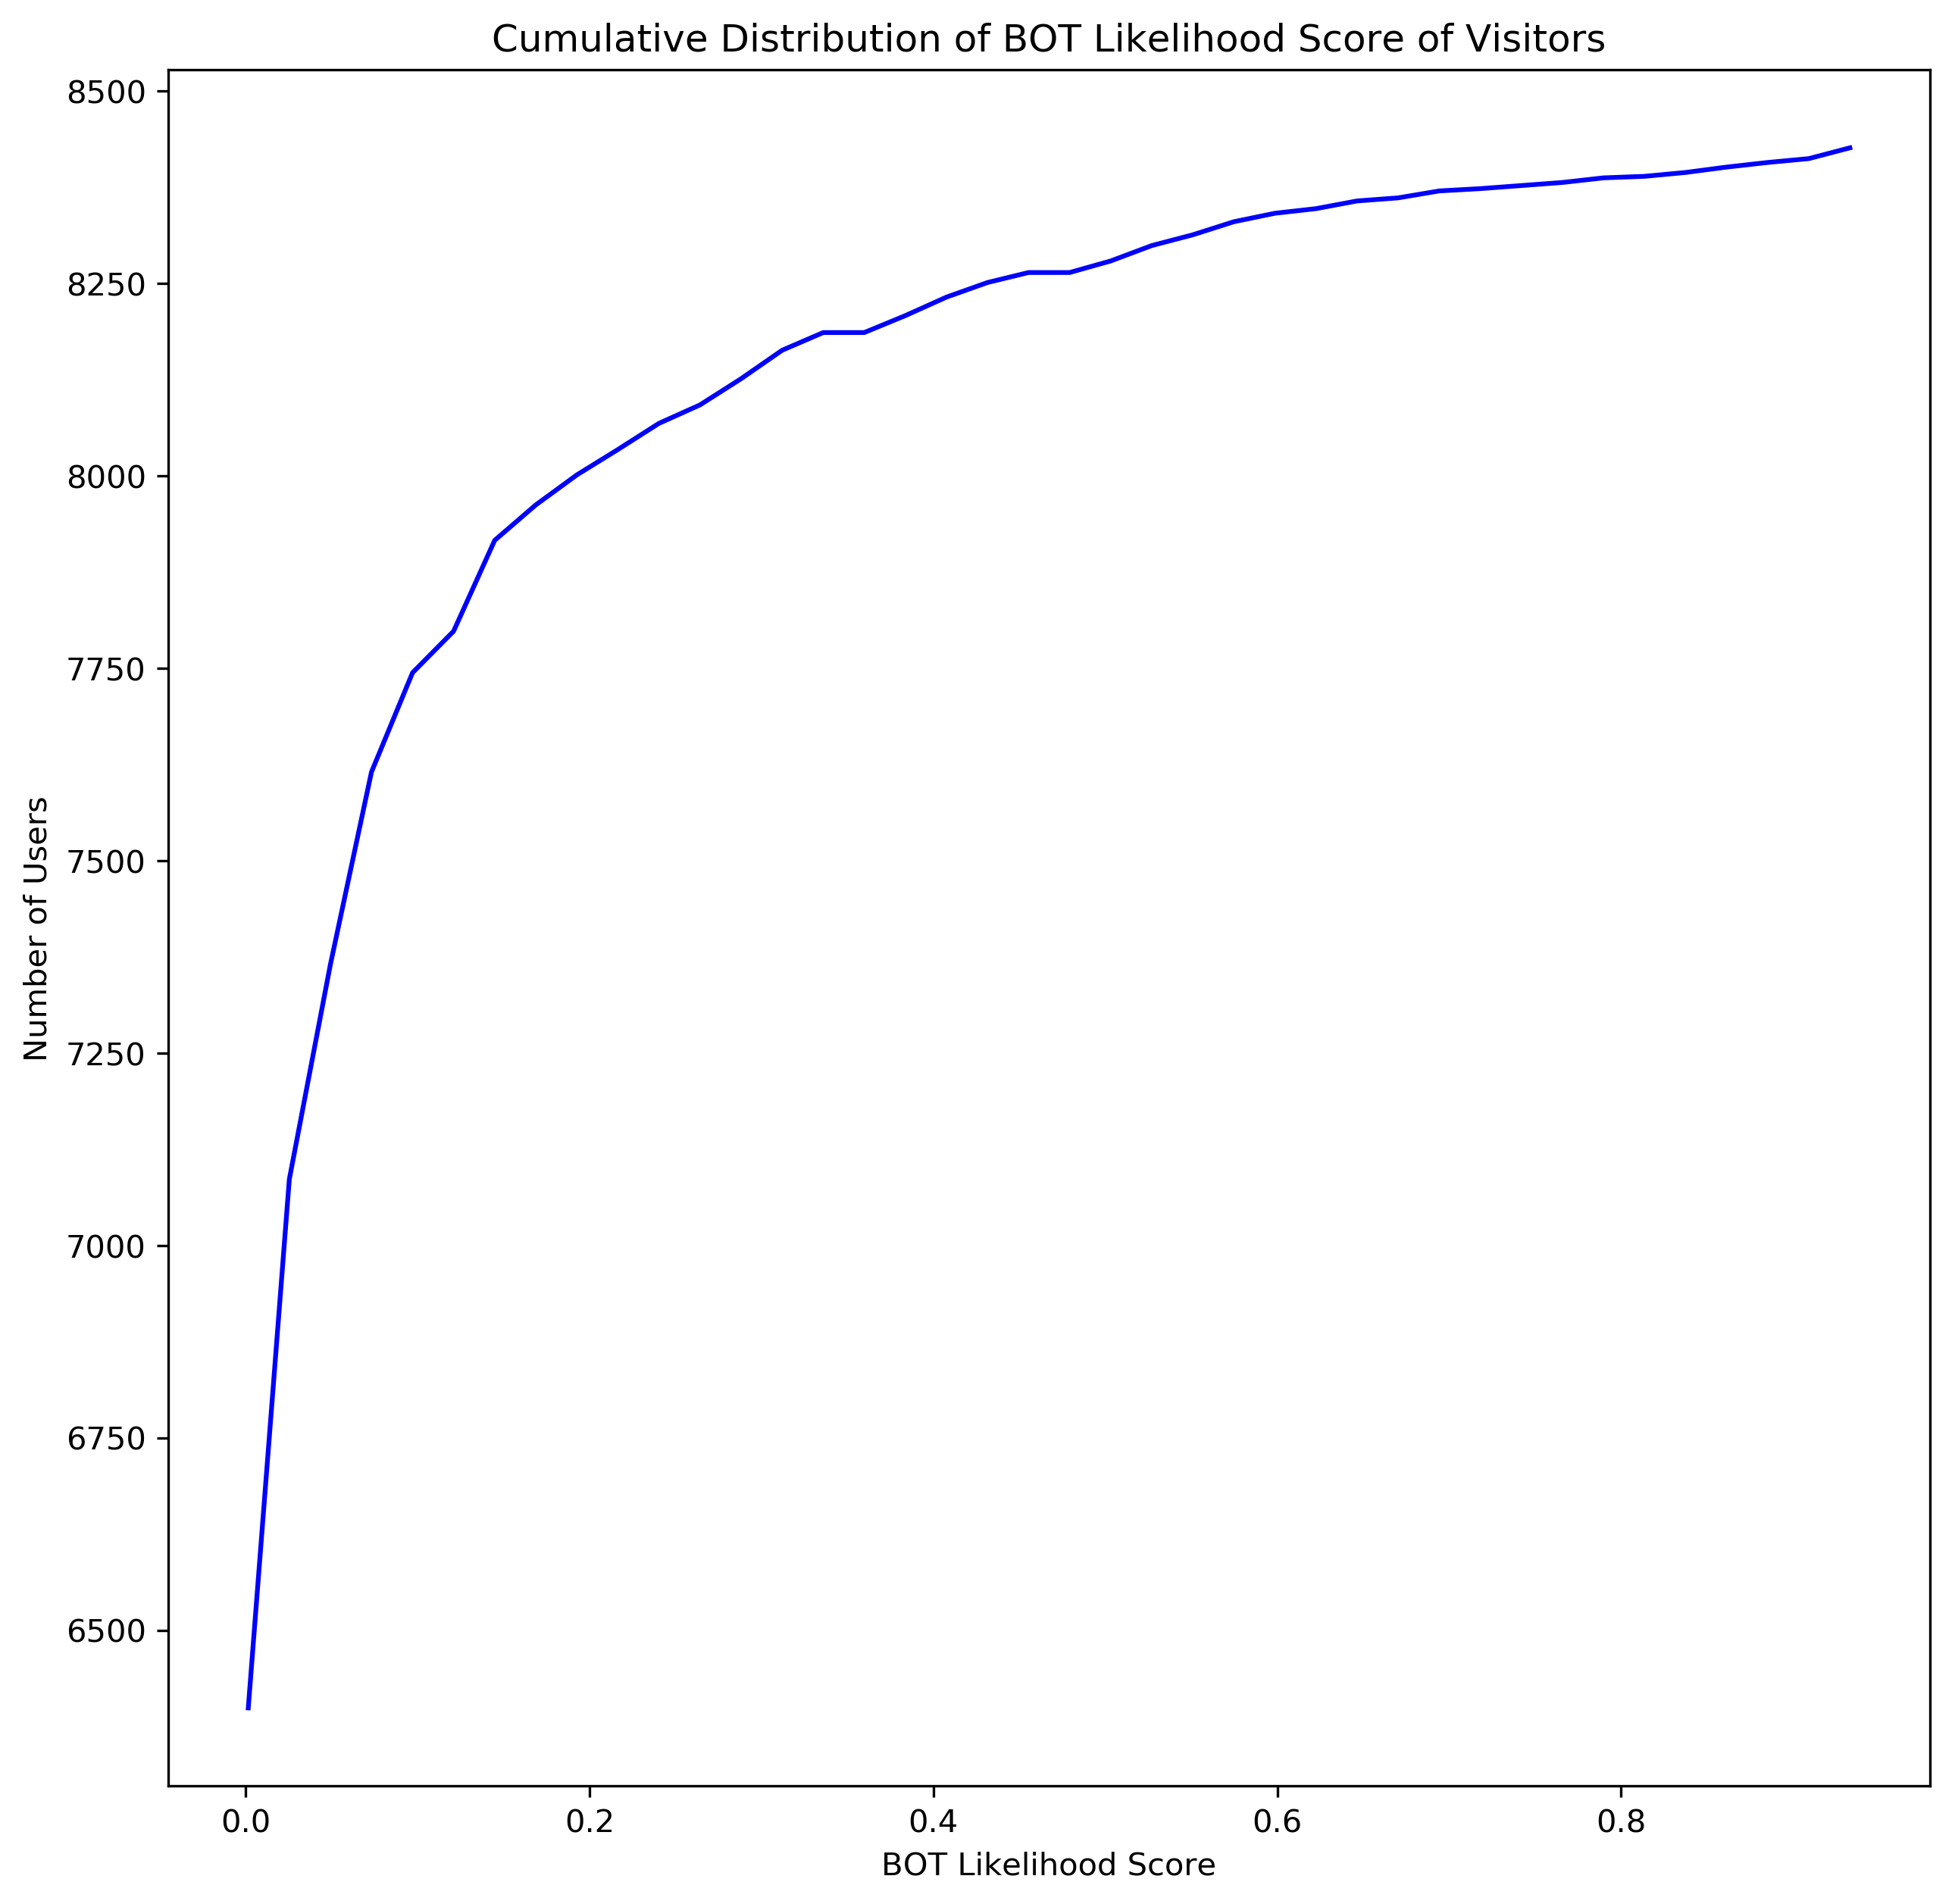

In [113]:
plot_cumulative(number_list=visitor_without_not_authorized_bot_score_list, bin_num=40, color='blue', 
                title='Cumulative Distribution of BOT Likelihood Score of Visitors', xlabel='BOT Likelihood Score', 
                ylabel='Number of Users', saving_path=desktop, 
                file_name='Cumulative_dist_bot_likelihood_score_visitor.png')

In [115]:
visitor_without_not_authorized_copy = visitor_without_not_authorized.copy()
visitor_without_not_authorized_copy['bot_score'] = visitor_without_not_authorized_copy['bot_score'].astype('float')
bot_visitor_dataframe = visitor_without_not_authorized_copy.loc[visitor_without_not_authorized_copy['bot_score'] > 0.4]

In [120]:
bot_visitor_dataframe_ids = list(bot_visitor_dataframe['account'])

In [122]:
visitor_without_bot_step2 = visitor_without_bot_step1.loc[~visitor_without_bot_step1['user_id_str'].isin(bot_visitor_dataframe_ids)]

In [123]:
visitor_without_bot_step2.shape

(54434, 47)

In [125]:
Counter(visitor_without_bot_step2['lang'])

Counter({'en': 44046, 'zh': 10388})

In [126]:
visitor_without_bot_step2.to_csv(os.path.join(visitor_data_save_path, 'final_visitor_filtered_data.csv'), encoding='utf-8', 
                                quoting=csv.QUOTE_NONNUMERIC)

In [127]:
number_of_tweet_user(visitor_without_bot_step2)

Total number of tweet is: 54434; Total number of user is 10236


In [130]:
visitor_without_bot_step2.columns

Index(['country', 'country_code', 'created_at', 'description', 'expanded_url',
       'favorited', 'favourites_count', 'followers_count', 'friends_count',
       'full_name', 'geo_enabled', 'id_str', 'in_reply_to_screen_name',
       'in_reply_to_status_id_str', 'in_reply_to_user_id_str', 'lang', 'lat',
       'listed_count', 'location', 'lon', 'name', 'place_id', 'place_lat',
       'place_lon', 'place_name', 'place_type', 'protected', 'retweet_count',
       'retweeted', 'screen_name', 'source', 'statuses_count', 'text',
       'time_zone', 'truncated', 'url', 'user_created_at', 'user_id_str',
       'user_lang', 'user_url', 'utc_offset', 'verified', 'hk_time', 'year',
       'month', 'month_plus_year', 'index_num'],
      dtype='object')

In [17]:
check_file = pd.read_csv(os.path.join(visitor_data_save_path, 'final_visitor_filtered_data.csv'), encoding='utf-8', 
                        quoting=csv.QUOTE_NONNUMERIC, index_col=0, dtype='str')

In [18]:
number_of_tweet_user(check_file)

Total number of tweet is: 54434; Total number of user is 10236
